# `numpy` Neural Networks: Single-Layer Perceptron

This is the first in a [series of notebooks](https://github.com/JohnPaton/numpy-neural-networks) I'm planning on making to illustrate deep learning concepts to myself using clear math and simple examples. None of the code here is meant to be very performant, there are optimized libraries for that. Rather, it's useful for me to organize my thoughts.

We consider the case of binary classification in 2D. So we have a 2D input, and a single number as an output.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Let's make a toy 2D dataset to play with. We won't bother with a test set for now. The point of these notebooks is to demonstrate deep learning concepts, not general machine learning best practices.

In [2]:
n_samples = 1000
X0 = np.random.normal(loc=[-1,4], scale=[1,0.5], size=(int(n_samples/2), 2))
X1 = np.random.normal(loc=[2,4], scale=[0.5,2], size=(int(n_samples/2), 2))
y0 = np.zeros(shape=(int(n_samples/2), ))
y1 = np.ones(shape=(int(n_samples/2), ))
X = np.vstack([X0, X1])
yhat = np.hstack([y0, y1])

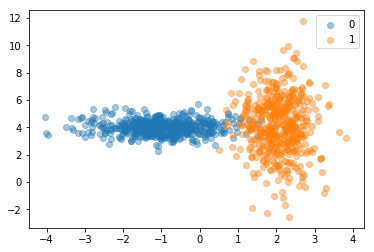

In [3]:
plt.scatter(*X[yhat==0].T, label='0', alpha=0.4); plt.scatter(*X[yhat==1].T, label='1', alpha=0.4)
plt.legend();

## Basic definitions

We will make use of the sigmoid the activation function:
$$ f(z) = \frac{1}{1+e^{-z}} $$

$$ \frac{\mathrm{d}f}{\mathrm{d}z} = f(z) \cdot (1-f(z)) $$

In [4]:
def f(z):
    return 1 / (1 + np.exp(-z))

def dfdz(z):
    return f(z) * (1 - f(z))

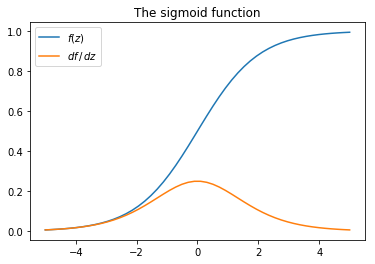

In [5]:
z = np.linspace(-5,5)
plt.plot(z, f(z), label='$f(z)$'); plt.plot(z, dfdz(z), label='$df\, /\,dz$'); plt.legend();
plt.title('The sigmoid function');

Each neuron (aka "unit") in the network accepts an array of inputs $x_i$ and has an associated weight vector $w_i$. The action of the unit is to take the inner product of $w$ and $x$ and pass this number through its activation function, $f$. So the output of a unit, $y$, is simply

$$ \mathrm{output} = f(w \cdot x) \equiv f(z) $$
where we defined $z = w\cdot x$.

If we have may layers, this output is then passed as input to the next layer of units. We will use the sigmoid function for all of our units. 


Our neural network will have only one output unit, $y$. The output is between 0 and 1, since it is the result of a sigmoid function. We will refer to the true labels as $\hat y$ ("y hat").

* Output: $y$, $0<y<1$
* True label: $\hat y$ (1 or 0)


The cost function we will try to minimize during training is called the cross-entropy loss and may be familiar from logistic regression:

$$ J(y, \hat y) = −(\hat y\log(y) + (1−\hat y)\log(1−y)) $$

$$ \frac{\partial J}{\partial y} = \frac{1-\hat y}{1-y} -\frac{\hat y}{y} $$

Note here that we are both taking the log of, and dividing by, the output of the neural network. We are hoping that this value will go to 0 or 1 to classify our samples. If we get close to dividing by or taking the log of 0, we can introduce some numerical instabilities in our algorithm. For that reason, we add a small constant `eps` whenever this is a danger.

In [6]:
def J(y, yhat):
    eps = 1e-8
    return -(yhat * np.log(y+eps) + (1-yhat) * np.log(1-y+eps))

def dJdy(y, yhat):
    eps = 1e-8
    return (1-yhat)/(1-y+eps) - yhat/(y+eps)

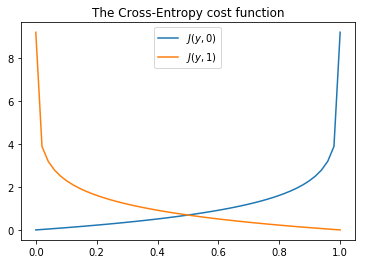

In [7]:
y = np.linspace(0.0001,0.9999)
plt.plot(y, J(y,0), label='$J(y,0)$'); plt.plot(y, J(y,1), label='$J(y,1)$'); plt.legend();
plt.title('The Cross-Entropy cost function');

## Prediction

This is basically just logistic regression.

* Input: $x_i$, $i=0,...,n$, where we fix $x_0 \equiv 1$ (the "bias term")
* Weights: $w_{i}$, $i=0,...,n$
* Output: 
$$y = f\left(\sum_i w_i x_i\right) = f(w \cdot x)$$

Calculating the output for a set of inputs and weights is called the feedforward pass, where we make a prediction.

In [8]:
def forward(x, w):
    return f(np.dot(x, w))

## Training

To figure out what the weights should be, we want to update them by stochastic gradient descent (one step per data pint) along the cost function. We should move down the gradient along the direction of each weight, taking steps of size $\alpha$. Then our update rule is:

$$ w_i \rightarrow w_i - \alpha \frac{\partial J}{\partial w_i}$$

Recall $z \equiv w\cdot x$. Then:

\begin{align*}
\frac{\partial J}{\partial w_i} &= \frac{\partial J(y, \hat y)}{\partial y} \frac{\partial y(z)}{\partial w_i}\\
 &= \frac{\partial J(y, \hat y)}{\partial y} \frac{\partial y(z)}{\partial z} \frac{ \partial z(w,x)}{\partial w_i} 
\end{align*}


Since $z = \sum x_i w_i$, we have $\partial z / \partial w_i = x_i$. Furthermore, $y(z) = f(z)$, so we already calculated this derivative above. We get:

\begin{align*}
\frac{\partial J}{\partial w_i} &= \left[\frac{1-\hat y}{1-y(z)} - \frac{\hat y}{y(z)} \right]\left[ y(z)(1-y(z)) \right]\left[ x_i \right]\\
&= \left(y(1-\hat y) - \hat y(1-y) \right)x_i
\end{align*}

So our update rule is

$$ w_i \rightarrow w_i - \alpha \left(y(1-\hat y) - \hat y(1-y) \right)x_i $$

We can implement this in Python using either the derivatives we calculated and implemented earlier, or using this explicit form.


In [9]:
## Option one: use the given derivatives (clearer)
def backward1(x, w, y, yhat):
    z = np.dot(x, w)
    dzdw = x
    return dJdy(y, yhat) * dfdz(z) * dzdw

## Option two: use the explicit calculted form (faster)
def backward2(x, y, yhat):  # w not needed for this form
    return ( y*(1-yhat) - yhat*(1-y) ) * x

def update(w, alpha, step):
    return w - alpha * step

Now it's time to train! The training prodecure is as follows. For each sample we:

1. Make our prediction $y$ based on the input sample $x$ (the forward pass)

2. Calculate the steps for updating the weights (the backward pass) and update them

We loop through the training set several times, making small updates to $w$ after each sample. Each single full cycle through the training set is called an "epoch".

In [10]:
def train(X, yhat, n_epoch, alpha):
    X_withbias = np.hstack([np.ones((X.shape[0],1)), X])  # fix x_0 = 1
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,))

    # random nonzero initialization
    w = np.random.normal(0, 0.01, size=(X.shape[1]+1,))  # +1 for the bias

    for epoch in range(n_epoch):
        for i, x in enumerate(X_withbias):
            y = forward(x, w)  # prediction for one sample
            step = backward2(x, y, yhat[i])  # step to take, yhat[i] to just get this sample
            w = update(w, alpha, step)  # update weights
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forward(X_withbias, w)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        
        # report progress
        if ((epoch % 10) == 0) or (epoch == (n_epoch - 1)):
            accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
            print('Training accuracy after epoch {}: {:.4%}'.format(epoch, accuracy))
            
    return w, costs

In [11]:
n_epoch = 250
alpha = 0.01

w, costs = train(X, yhat, n_epoch, alpha)    

Training accuracy after epoch 0: 55.0000%
Training accuracy after epoch 10: 95.4000%
Training accuracy after epoch 20: 96.7000%
Training accuracy after epoch 30: 97.1000%
Training accuracy after epoch 40: 97.3000%
Training accuracy after epoch 50: 97.3000%
Training accuracy after epoch 60: 97.2000%
Training accuracy after epoch 70: 97.2000%
Training accuracy after epoch 80: 97.4000%
Training accuracy after epoch 90: 97.4000%
Training accuracy after epoch 100: 97.4000%
Training accuracy after epoch 110: 97.7000%
Training accuracy after epoch 120: 97.7000%
Training accuracy after epoch 130: 97.8000%
Training accuracy after epoch 140: 97.9000%
Training accuracy after epoch 150: 97.9000%
Training accuracy after epoch 160: 97.9000%
Training accuracy after epoch 170: 97.9000%
Training accuracy after epoch 180: 97.9000%
Training accuracy after epoch 190: 97.9000%
Training accuracy after epoch 200: 97.9000%
Training accuracy after epoch 210: 97.9000%
Training accuracy after epoch 220: 97.9000%

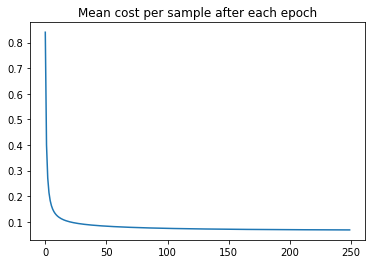

In [12]:
plt.plot(costs); plt.title('Mean cost per sample after each epoch');

Since we're working in 2D, we can visualize the function learned by our simple network as a heatmap.

In [13]:
x1 = np.linspace(-6,6,250)
x2 = np.linspace(-6,12,250)
fun_map = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map[m,n] = forward([1,i,j], w)

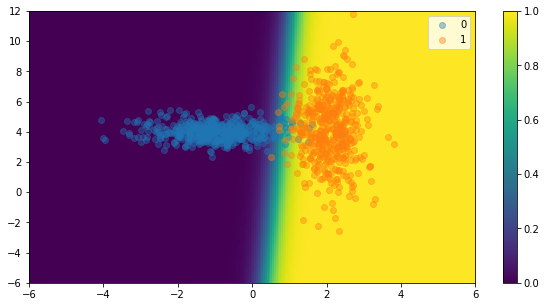

In [14]:
plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(),x1.max(),x2.min(),x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X[yhat==0].T, label='0', alpha=0.4); plt.scatter(*X[yhat==1].T, label='1', alpha=0.4)
plt.legend();plt.legend();

Looks pretty good!

## Non-linear decision boundaries

We see that the boundary learned by our network is just a line. This isn't surprising, since we're basically just doing logistic regression with no polynomial features. What happens with a less easy dataset?

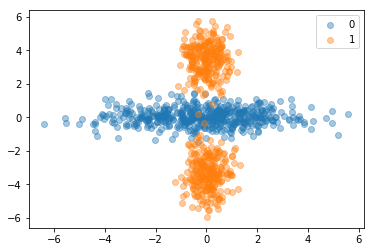

In [15]:
n_samples = 1000
X0 = np.random.normal(loc=[0,0], scale=[2,0.5], size=(int(n_samples/2), 2))
X11 = np.random.normal(loc=[0,3.5], scale=[0.5,1], size=(int(n_samples/4), 2))
X12 = np.random.normal(loc=[0,-3.5], scale=[0.5,1], size=(int(n_samples/4), 2))
X1 = np.vstack([X11, X12])
y0 = np.zeros(shape=(int(n_samples/2), ))
y1 = np.ones(shape=(int(n_samples/2), ))
X = np.vstack([X0, X1])
yhat = np.hstack([y0, y1])

plt.scatter(*X[yhat==0].T, label='0', alpha=0.4); plt.scatter(*X[yhat==1].T, label='1', alpha=0.4)
plt.legend();

In [16]:
n_epoch = 250
alpha = 0.001

w, costs = train(X, yhat, n_epoch, alpha)    

Training accuracy after epoch 0: 51.2000%
Training accuracy after epoch 10: 44.5000%
Training accuracy after epoch 20: 44.4000%
Training accuracy after epoch 30: 44.4000%
Training accuracy after epoch 40: 44.4000%
Training accuracy after epoch 50: 44.4000%
Training accuracy after epoch 60: 44.4000%
Training accuracy after epoch 70: 44.4000%
Training accuracy after epoch 80: 44.4000%
Training accuracy after epoch 90: 44.4000%
Training accuracy after epoch 100: 44.4000%
Training accuracy after epoch 110: 44.4000%
Training accuracy after epoch 120: 44.4000%
Training accuracy after epoch 130: 44.4000%
Training accuracy after epoch 140: 44.4000%
Training accuracy after epoch 150: 44.4000%
Training accuracy after epoch 160: 44.4000%
Training accuracy after epoch 170: 44.4000%
Training accuracy after epoch 180: 44.4000%
Training accuracy after epoch 190: 44.4000%
Training accuracy after epoch 200: 44.4000%
Training accuracy after epoch 210: 44.4000%
Training accuracy after epoch 220: 44.4000%

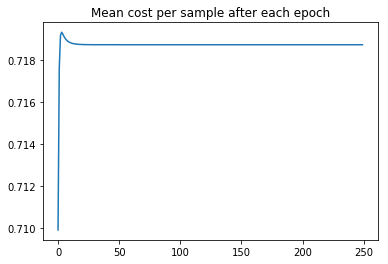

In [17]:
plt.plot(costs); plt.title('Mean cost per sample after each epoch');

In [18]:
x1 = np.linspace(-8,8,250)
x2 = np.linspace(-10,10,250)
fun_map = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map[m,n] = forward([1,i,j], w)

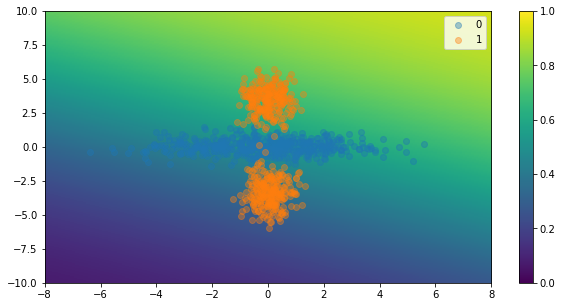

In [19]:
plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(),x1.max(),x2.min(),x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X[yhat==0].T, label='0', alpha=0.4); plt.scatter(*X[yhat==1].T, label='1', alpha=0.4)
plt.legend();

We see that the performance is terrible (sometimes actually worse than random guessing!) and training stalls out pretty much immediately without making any progress. Also, the gradient of the learned function is very shallow, which we can interpret as the model being very uncertain about what it should output.

If we want to predict this dataset, we'll need something more flexible!